# LIG SST Visualization: Empirical Orthogonal Function
## Updated 05/05, Anna Chen

## EOF (PCA) for HadISST v1.1 modern SST model training
#### Initiated: 04/16
#### Edit 1: 05/01
#### Edit 2: 05/05

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import geopandas as gpd
import geodatasets
import netCDF4

import xarray as xr
from scipy.interpolate import griddata

import sys
np.set_printoptions(threshold=sys.maxsize)

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

import warnings
# Filter out warnings from openpyxl regarding unknown extensions.
warnings.filterwarnings("ignore", message="Unknown extension is not supported and will be removed")
# Filter out pyproj warnings regarding converting masked elements to nan.
warnings.filterwarnings("ignore", message="Warning: converting a masked element to nan.")

In [2]:
# Open the Excel file and retrieve sheet names
excel_file = "SST_Hoffman_Harmonized_AC_ES.xlsx"
xls = pd.ExcelFile(excel_file)
sheet_names = xls.sheet_names

# List of sheet names to remove
sheets_to_remove = [
    "Reference Cores Tie Points",
    "Fig1 Global & Regional Stacks",
    "HadSST & SynTrACE Bias Estimate",
    "TEMPLATE",
    "NATL Data Read Me",
    "PAC Data Read Me",
    "IND Data Read Me",
    "SATL Data Read Me"
]

# Remove each sheet in sheets_to_remove if it exists in core_ID_list
for sheet in sheets_to_remove:
    if sheet in sheet_names:
        sheet_names.remove(sheet)

        # Initialize a list to hold (longitude, latitude) tuples.
lon_lat = []

# Loop through every sheet, but only process if not in sheets_to_remove.
for sheet in xls.sheet_names:
    if sheet in sheets_to_remove:
        continue  # Skip sheets in the remove list

    try:
        # Read only columns B and C from the first two rows.
        # Note: Excel row 2 corresponds to index 1 in pandas.
        df_sheet = pd.read_excel(excel_file, sheet_name=sheet, header=None, usecols="B:C", nrows=2)
        
        # Ensure that there are at least two rows in the sheet.
        if df_sheet.shape[0] < 2:
            continue
        
        # Extract longitude from cell B2 and latitude from cell C2.
        lon = df_sheet.iloc[1, 0]
        lat = df_sheet.iloc[1, 1]
        
        # Try converting the values to float; if conversion fails, skip this sheet.
        try:
            lon_val = float(lon)
            lat_val = float(lat)
            lon_lat.append((lon_val, lat_val))
        except (ValueError, TypeError):
            continue  # Skip if conversion to float fails
    except Exception as e:
        print(f"Error processing sheet '{sheet}': {e}")

# Create a DataFrame from the list of tuples.
df_coords = pd.DataFrame(lon_lat, columns=["longitude", "latitude"])

# Order the rows of the DF from the largest longitude to the smallest
df_coords = df_coords.sort_values('longitude', ascending=False)

# Correct rounding method

# Remove rows that contain any NaN values and any duplicated rows.
df_coords = df_coords.dropna().drop_duplicates().reset_index(drop=True)

def round_to_nearest_half(x):
    """Round to nearest 0.5, always ending with .5"""
    base = np.floor(x)  # Get integer part
    
    return base + 0.5

# Round coordinates
df_coords['longitude'] = df_coords['longitude'].apply(round_to_nearest_half)
df_coords['latitude'] = df_coords['latitude'].apply(round_to_nearest_half)

# Clip to valid ranges
df_coords['longitude'] = df_coords['longitude'].clip(lower=-179.5, upper=179.5)
df_coords['latitude'] = df_coords['latitude'].clip(lower=-89.5, upper=89.5)

# Drop four duplicated rows
# (174.5, -45.5)
# (51.5, -43.5)
# (-14.5, 55.5)
# (-118.5, 32.5)
df_coords = df_coords.drop_duplicates().reset_index(drop=True)

# Display the coordinates from Hoffman 2017
pd.set_option('display.max_rows', None)
print('The coordinates of non-duplicated 82 cores in Hoffman et al.(2017), rounded to the nearest 0.5ºx0.5º, is as follows:', '\n')
print(df_coords)

The coordinates of non-duplicated 82 cores in Hoffman et al.(2017), rounded to the nearest 0.5ºx0.5º, is as follows: 

    longitude  latitude
0       177.5     -40.5
1       177.5     -48.5
2       174.5     -45.5
3       169.5     -50.5
4       166.5     -22.5
5       160.5       1.5
6       149.5     -48.5
7       146.5     -45.5
8       141.5      36.5
9       121.5     -13.5
10      117.5     -17.5
11      117.5      19.5
12      116.5      19.5
13      112.5       8.5
14      109.5       8.5
15      103.5      -5.5
16       96.5     -46.5
17       90.5       9.5
18       88.5     -46.5
19       79.5     -43.5
20       79.5     -42.5
21       59.5      16.5
22       51.5     -43.5
23       19.5     -36.5
24       18.5     -35.5
25       12.5     -23.5
26       11.5     -23.5
27       11.5     -22.5
28       11.5     -25.5
29        9.5     -40.5
30        9.5       2.5
31        8.5     -42.5
32        5.5      67.5
33        5.5      -2.5
34       -5.5      45.5
35       -9.5    

### Previous notebook: visualization of Hoffman et al.'s original data

Enter a specific year before present (e.g., 115000):  127000


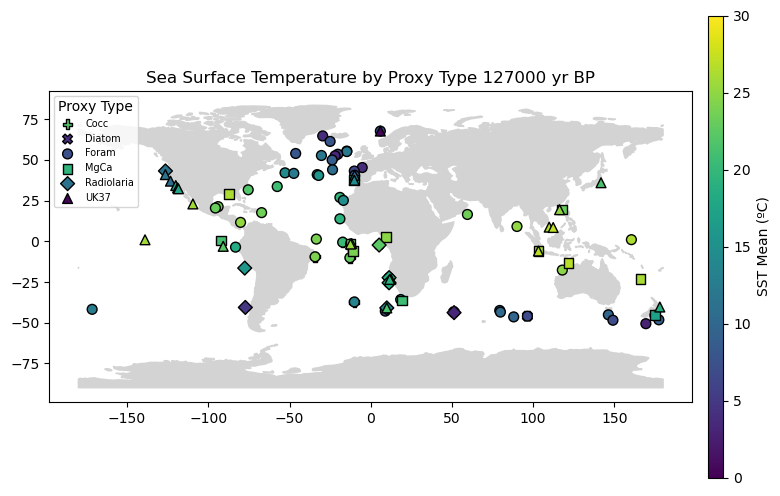

The data frame of records 127000 yr BP is:
               ID  Longitude  Latitude       Proxy        SST    SST+2sd  \
0        M23323-1       5.92     67.77        UK37   0.390805  11.002641   
1        M23323-1       5.92     67.77       Foram   7.292697  12.349014   
2          V28-14     -29.57     64.78       Foram   3.846172  11.966761   
3     EW9302-JCP8     -25.00     61.42       Foram   7.970303  16.595263   
4         ODP 980     -14.70     55.48       Foram   7.725748  17.785723   
5         NA87-25     -14.73     55.18       Foram  12.133936  17.926161   
6          V27-20     -46.20     54.00       Foram   8.035149  13.087240   
7        M23414-9     -20.29     53.53       Foram   5.786810  14.340496   
8         NEAP18K     -30.35     52.76       Foram  12.041295  19.376967   
9          V23-82     -21.93     52.58       Foram   3.138139  13.398880   
10         K708-1     -23.74     50.00       Foram   8.814598  17.068364   
11      MD04-2845      -5.22     45.35       

In [42]:
# Define proxy marker mapping
proxy_marker_map = {
    "Foram": "o",      # Circle
    "UK37": "^",       # Triangle
    "MgCa": "s",       # Square
    "Radiolaria": "D", # Diamond
    "Cocc": "P",       # Plus
    "Diatom": "X"      # Filled-X
}

def extract_record_for_sheet(sheet, year_input):
    """
    For a given sheet name and year:
      - Reads columns B, C, D (Longitude, Latitude, Proxy) and extracts row 2 (first data row).
      - Reads columns Q and S (Age and SST Mean), finds the row where Age matches the given year,
        and extracts the SST Mean.
      - Returns a dictionary with keys: "Longitude", "Latitude", "Proxy", and "SST".
      - If no matching year is found, returns None.
    """
    try:
        # Read base info (columns B, C, D) from row 2 only.
        df_base = pd.read_excel(excel_file, sheet_name=sheet, usecols="A,B,C,D")
        df_base.columns = ['ID', 'Longitude', 'Latitude', 'Proxy']
        # Row 2 is the first data row (index 0)
        ID = df_base.iloc[0]['ID']
        lon = df_base.iloc[0]['Longitude']
        lat = df_base.iloc[0]['Latitude']
        proxy = df_base.iloc[0]['Proxy']
    except Exception as e:
        print(f"Error reading base info from sheet {sheet}: {e}")
        return None

    try:
        # Read age and SST info (columns Q and S) for all rows.
        df_sst = pd.read_excel(excel_file, sheet_name=sheet, usecols="R,T,S,U")
        df_sst.columns = ['Age', 'SST', 'SST-2sd', 'SST+2sd']
        # Find the row where Age matches the entered year.
        match = df_sst[df_sst['Age'] == year_input]
        if match.empty:
            print(f"Year {year_input} not found in sheet {sheet}.")
            return None
        # Extract the SST value from the first matching row.
        sst_val = match.iloc[0]['SST']
        sst_upper_val = match.iloc[0]['SST+2sd']
        sst_lower_val = match.iloc[0]['SST-2sd']
    except Exception as e:
        print(f"Error reading SST info from sheet {sheet}: {e}")
        return None

    return {"ID": ID, "Longitude": lon, "Latitude": lat, "Proxy": proxy,
            "SST": sst_val, "SST+2sd": sst_upper_val, "SST-2sd": sst_lower_val}

def build_gdf(year_input):
    """
    Loop through all sheets, extract records for the given year, and return a DataFrame.
    """
    records = []
    for sheet in sheet_names:
        rec = extract_record_for_sheet(sheet, year_input)
        if rec is not None:
            records.append(rec)
    if records:
        return pd.DataFrame(records)
    else:
        return pd.DataFrame()

def plot_proxy_data(gdf):
    """
    Plots the data grouped by proxy type onto a world map.
    """
    # Set up colormap and fixed normalization from 5 to 30 ºC.
    cmap = plt.cm.viridis
    norm = colors.Normalize(vmin=0, vmax=30)

    # Load world map from geodatasets via GeoPandas.
    world = gpd.read_file(geodatasets.data.naturalearth.land['url'])

    # Create the plot.
    fig, ax = plt.subplots(figsize=(10, 6))
    world.plot(ax=ax, color='lightgrey', edgecolor='lightgrey')

    # Group the data by proxy type and plot each group.
    for proxy, group in gdf.groupby("Proxy"):
        ax.scatter(
            group['Longitude'], group['Latitude'],
            marker=proxy_marker_map.get(proxy, "o"),
            c=group['SST'],
            cmap=cmap, norm=norm,
            edgecolor="black", s=50,
            label=proxy
        )

    # Add a colorbar for SST values.
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02, aspect=30)
    cbar.set_label("SST Mean (ºC)")

    # Add legend for proxy types.
    ax.legend(title="Proxy Type", loc='upper left', prop={'size': 7})
    plt.title(f"Sea Surface Temperature by Proxy Type {year_input} yr BP")
    plt.show()

if __name__ == "__main__":
    try:
        year_input = int(input("Enter a specific year before present (e.g., 115000): "))
    except ValueError:
        print("Invalid year input.")
        exit()

    # Build the DataFrame of records.
    gdf = build_gdf(year_input)
    if gdf.empty:
        print("No records found for the given year.")
    else:
        # Plot the data grouped by proxy type.
        plot_proxy_data(gdf)

    # Print the DataFrame of records.
    print(f"The data frame of records {year_input} yr BP is:")
    print(gdf)

### HadISST Modern 1870-1969 century data visualization and EOF reconstruction

Time range: 1870-01-16T11:59:59.505615234 to 1969-12-16T12:00:00.000000000
<xarray.Dataset>
Dimensions:     (latitude: 180, longitude: 360, year: 100)
Coordinates:
  * latitude    (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude   (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * year        (year) int64 1870 1871 1872 1873 1874 ... 1966 1967 1968 1969
Data variables:
    annual_sst  (year, latitude, longitude) float32 -1.8 -1.8 -1.8 ... nan nan


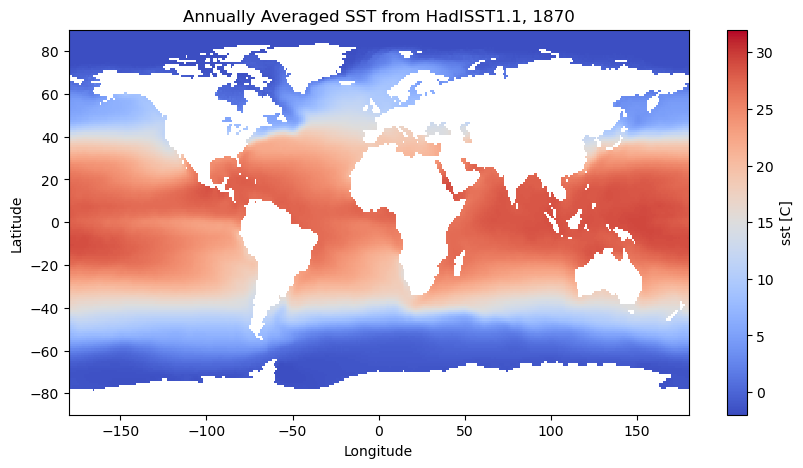

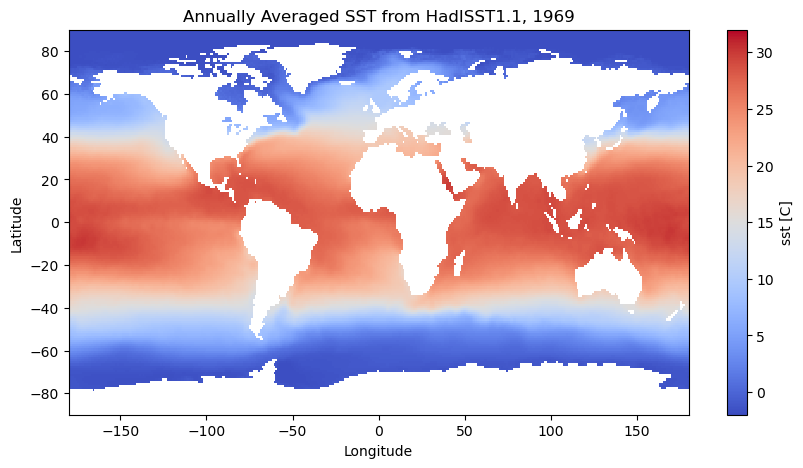

In [4]:
#HadISST

# Load netCDF dataset
HadISST = xr.open_dataset('HadISST_sst.nc')

# Clamp SST values: only keep values that are greater than -10.
# Values that are not greater than -10 are replaced with NaN.
HadISST = HadISST.where(HadISST.sst > -10)

# Only use the first 100 years of data, which is 1200 months
HadISST = HadISST.isel(time=slice(0, 1200))

# Verify the time range (should be 1870 to 1970)
print("Time range:", HadISST.time.min().values, "to", HadISST.time.max().values)

# Group the monthly SST data by the year component of the time coordinate, then average over the time dimension.
# This computes the mean of available months for each year.
HadISST_annual = HadISST.sst.groupby('time.year').mean('time', skipna=True)

# Optionally, convert the resulting DataArray to a Dataset with the variable name 'annual_sst'
HadISST_annual_ds = HadISST_annual.to_dataset(name='annual_sst')

# Check the resulting dataset
print(HadISST_annual_ds)

# Plot the first year (1870) and the last year (
1969)

# Plot the first year's SST with a colorbar from -2ºC to 32ºC.
fig, ax = plt.subplots(figsize=(10, 5))
HadISST_annual_ds.annual_sst.sel(year=1870).plot(
    ax=ax, 
    vmin=-2, 
    vmax=32, 
    cmap='coolwarm',
    add_colorbar=True
)
ax.set_title("Annually Averaged SST from HadISST1.1, 1870")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# Plot the last year's SST with a colorbar from -2ºC to 32ºC.
fig, ax = plt.subplots(figsize=(10, 5))
HadISST_annual_ds.annual_sst.sel(year=1969).plot(
    ax=ax, 
    vmin=-2, 
    vmax=32, 
    cmap='coolwarm',
    add_colorbar=True
)
ax.set_title("Annually Averaged SST from HadISST1.1, 1969")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

### New Code for avergaed 100-yr PC

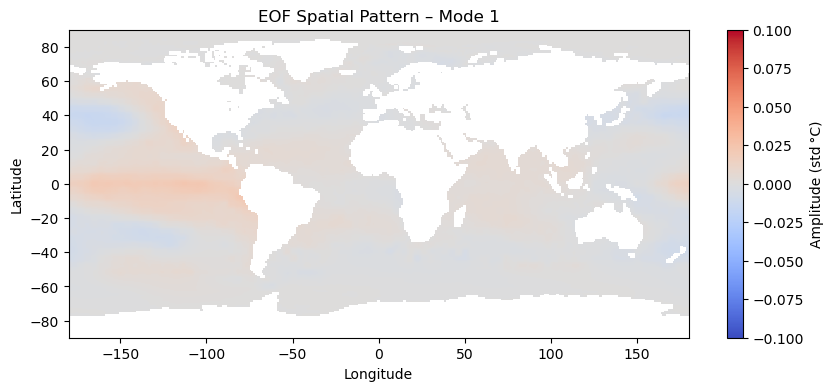

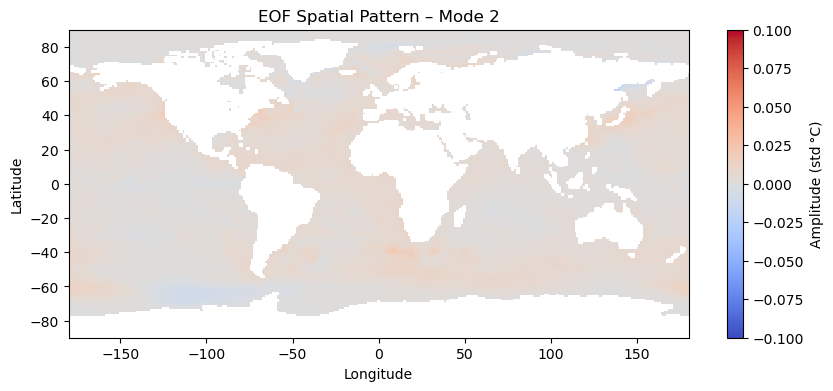

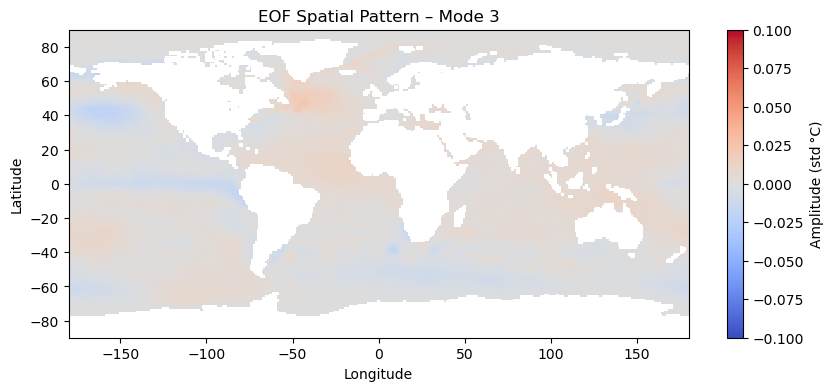

Modes 1–1 explain 23.7% of the variance.
Modes 1–2 explain 46.5% of the variance.
Modes 1–3 explain 52.4% of the variance.


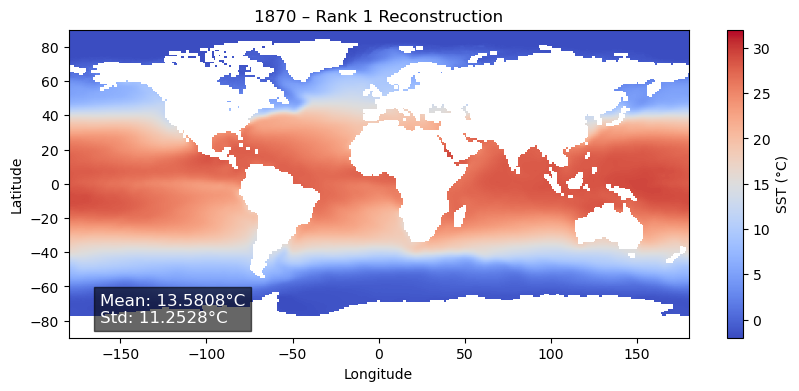

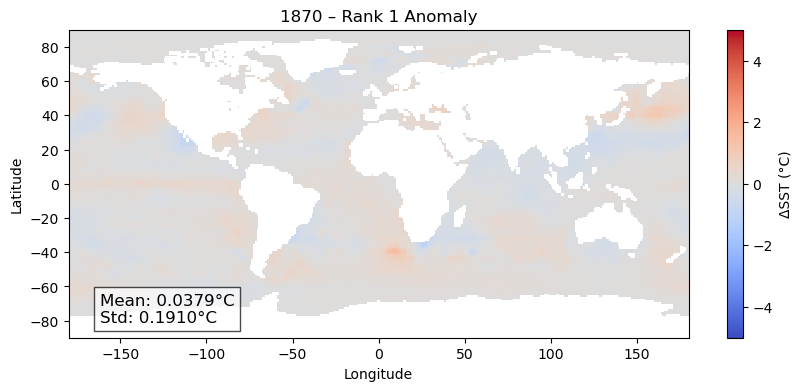

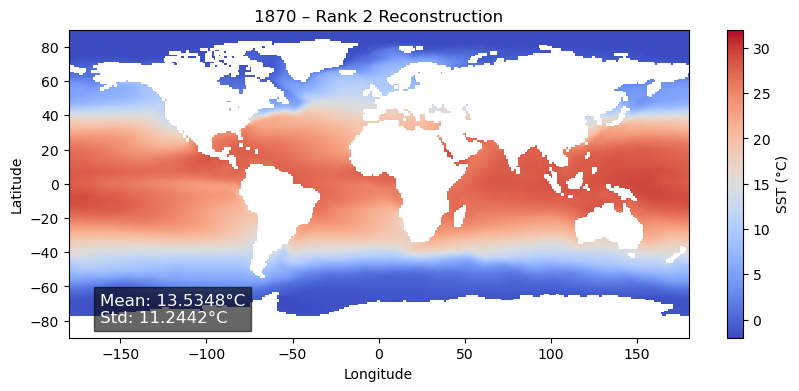

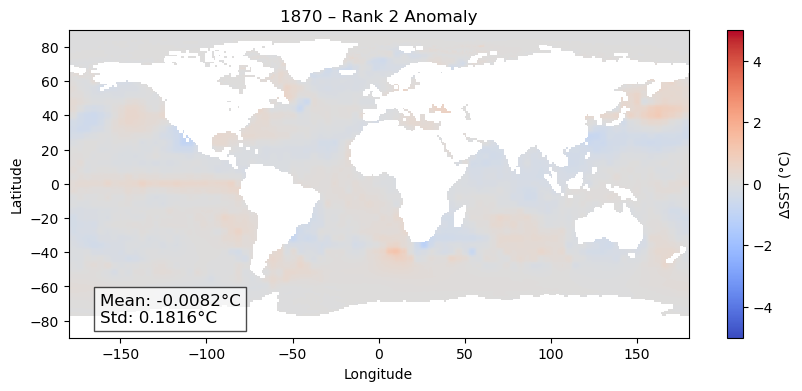

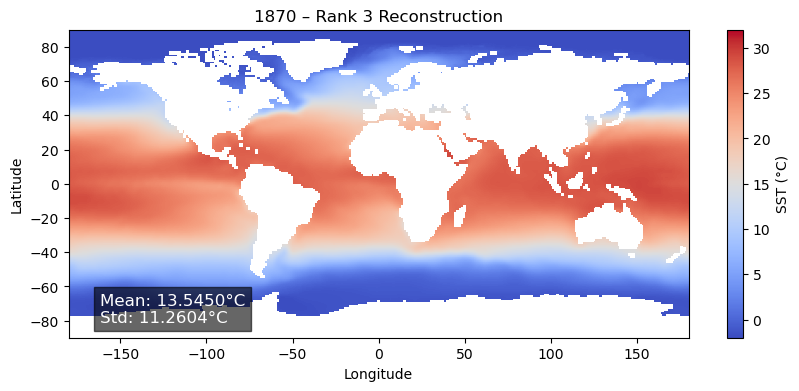

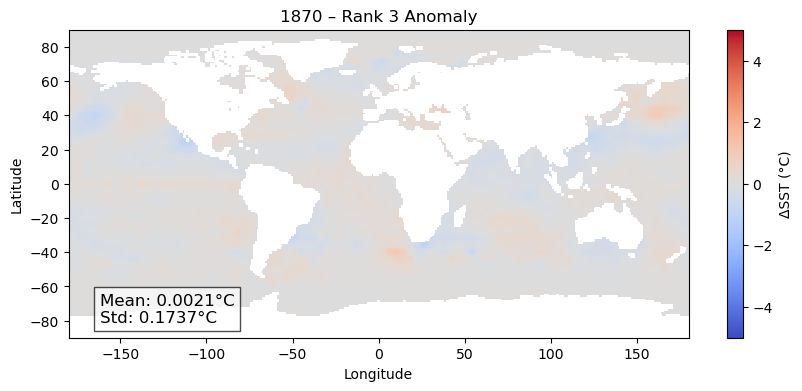

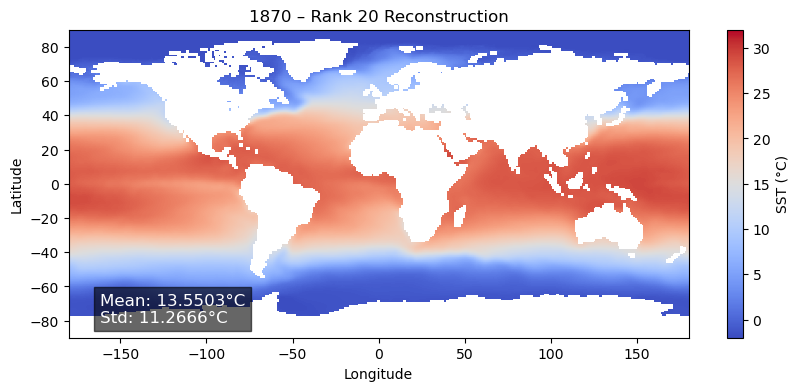

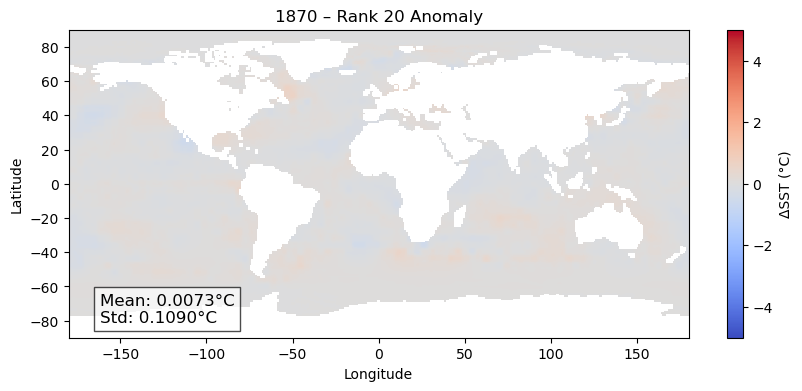

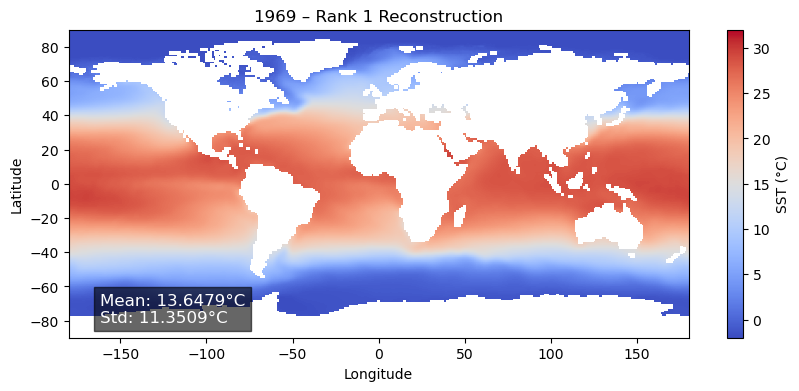

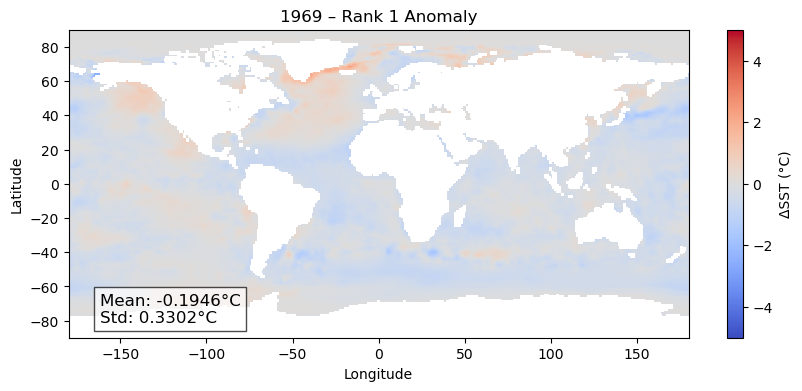

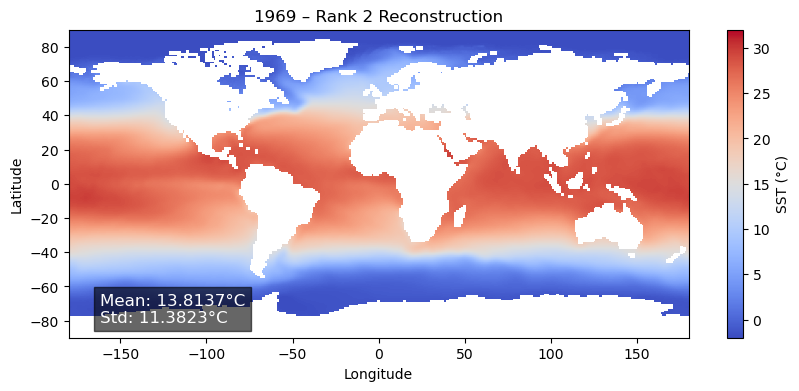

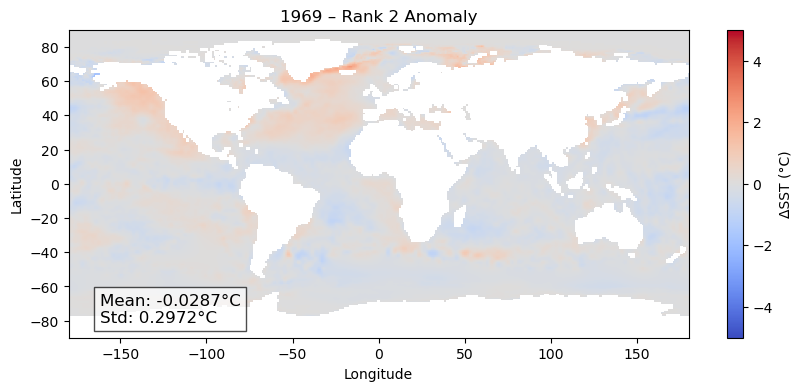

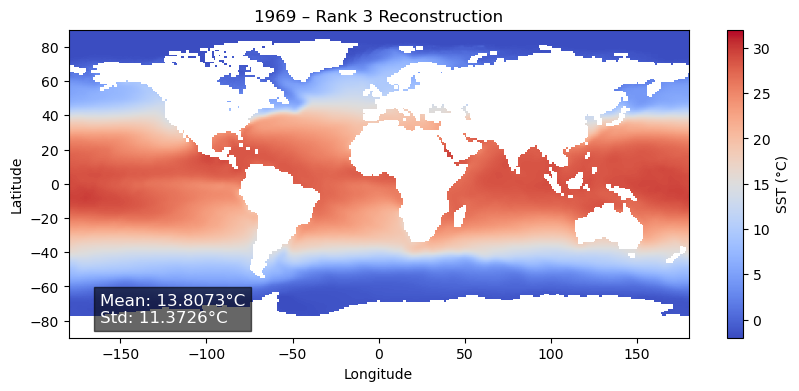

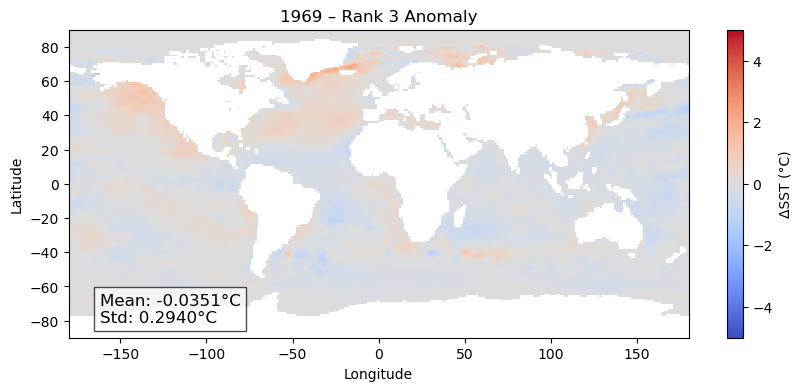

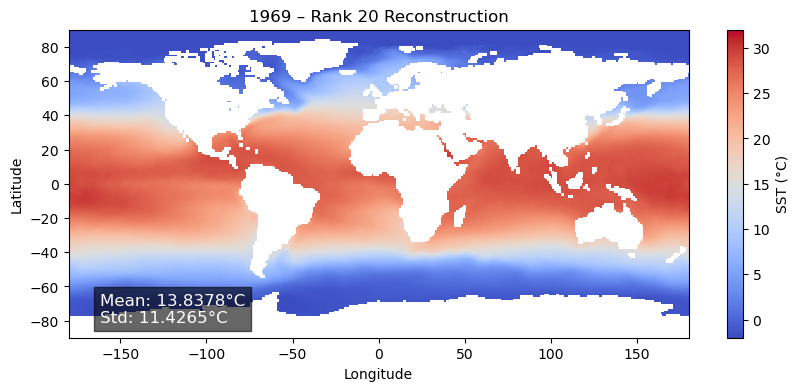

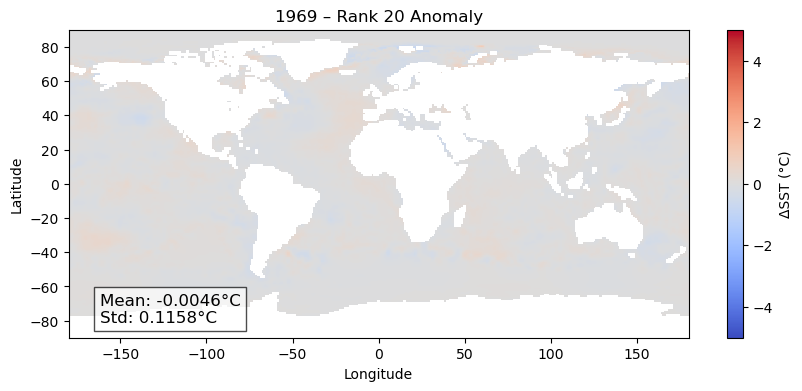

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

# -------------------------------------------------------------------
# Use ALL 100 years (no train/test split) via df_subset
# -------------------------------------------------------------------

# Make sure latitude runs from -90 to +90 (so row 0 is southernmost)
HadISST_annual_ds = HadISST_annual_ds.sortby('latitude')

# 1) Reconstruct df_global and df_subset
df_global = HadISST_annual_ds.annual_sst.to_dataframe().reset_index()
df_subset = pd.merge(df_global, df_coords, on=['latitude', 'longitude'], how='inner')
df_subset = df_subset[df_subset['annual_sst'] > -1.8]  # drop land/sea-ice

# 2) Compute full-dataset standardization
mean_sst = df_global['annual_sst'].mean()
std_sst  = df_global['annual_sst'].std()

df_global['sst_std'] = (df_global['annual_sst'] - mean_sst) / std_sst
df_subset['sst_std'] = (df_subset['annual_sst'] - mean_sst) / std_sst

# 3) Build PCA matrix and fit EOF on the global grid
mask_3d = (~df_global['annual_sst'].isnull()).values.reshape(-1, 180, 360)
mask2d = mask_3d.any(axis=0)           # shape (180,360)
valid_indices = np.where(mask2d.ravel())[0]

pca_matrix = df_global['sst_std'].values.reshape(-1, 180*360)[:, valid_indices]
imputer = SimpleImputer(strategy='mean')
pca_matrix_imputed = imputer.fit_transform(pca_matrix)

n_modes = 20
pca = PCA(n_components=n_modes)
pc_scores = pca.fit_transform(pca_matrix_imputed)  # (100 years × 20 modes)

# 4) Build regression from the 82 core SSTs → PC scores
core_pivot = df_subset.pivot(
    index='year',
    columns=['latitude', 'longitude'],
    values='sst_std'
)
X = core_pivot.values     # (100 × 82)
y = pc_scores             # (100 × 20)

regressor = LinearRegression()
regressor.fit(X, y)

# Precompute extent for imshow
lons = HadISST_annual_ds.longitude.values
lats = HadISST_annual_ds.latitude.values
extent = [lons.min(), lons.max(), lats.min(), lats.max()]

# 5) Plot the FIRST THREE EOF spatial patterns
for i in range(3):
    eof_vec = np.full(180*360, np.nan)
    eof_vec[valid_indices] = pca.components_[i]
    eof_map = eof_vec.reshape(180, 360)
    
    fig, ax = plt.subplots(figsize=(10, 4))
    im = ax.imshow(
        eof_map,
        origin='lower',
        extent=extent,
        aspect='auto',
        cmap='coolwarm',
        vmin=-np.abs(eof_map).max(),
        vmax= np.abs(eof_map).max()
    )
    ax.set_title(f'EOF Spatial Pattern – Mode {i+1}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90,  90)
    fig.colorbar(im, ax=ax, label='Amplitude (std °C)')
    plt.show()

# 6) Print explained-variance fractions for modes 1–3
evr = pca.explained_variance_ratio_
for r in [1,2,3]:
    print(f'Modes 1–{r} explain {evr[:r].sum()*100:.1f}% of the variance.')

# 7) Reconstruct & plot for 1870 & 1969 at rank-1,2,3 and full-20
years = [1870, 1969]
ranks = [1, 2, 3, 'full']

for year in years:
    core_vals = df_subset.loc[df_subset['year'] == year, 'annual_sst'].values
    std_core  = (core_vals - mean_sst) / std_sst
    pc_pred   = regressor.predict([std_core])[0]  # length 20
    
    for r in ranks:
        # truncate PCs
        pc_trunc = pc_pred.copy()
        if r != 'full':
            pc_trunc[r:] = 0
        
        # inverse transform → standardized grid
        recon_std_valid = pca.inverse_transform(pc_trunc.reshape(1, -1))[0]
        full_std = np.full(180*360, np.nan)
        full_std[valid_indices] = recon_std_valid
        recon_map = full_std.reshape(180, 360) * std_sst + mean_sst
        
        # compute global mean & std of reconstruction
        mean_recon = np.nanmean(recon_map)
        std_recon  = np.nanstd(recon_map)
        
        # Plot reconstruction
        fig, ax = plt.subplots(figsize=(10, 4))
        im = ax.imshow(
            recon_map,
            origin='lower',
            extent=extent,
            aspect='auto',
            cmap='coolwarm',
            vmin=-2, vmax=32
        )
        ax.set_title(f'{year} – Rank {r if r!="full" else n_modes} Reconstruction')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_xlim(-180, 180)
        ax.set_ylim(-90,  90)
        # add mean & std
        ax.text(
            0.05, 0.05,
            f'Mean: {mean_recon:.4f}°C\nStd: {std_recon:.4f}°C',
            transform=ax.transAxes,
            fontsize=12,
            color='white',
            bbox=dict(facecolor='black', alpha=0.6)
        )
        fig.colorbar(im, ax=ax, label='SST (°C)')
        plt.show()
        
        # Plot anomaly (reconstruction – real)
        real_map = HadISST_annual_ds.annual_sst.sel(year=year).values
        diff = recon_map - real_map
        
        # compute mean & std of anomaly
        mean_diff = np.nanmean(diff)
        std_diff  = np.nanstd(diff)
        
        fig, ax = plt.subplots(figsize=(10, 4))
        im = ax.imshow(
            diff,
            origin='lower',
            extent=extent,
            aspect='auto',
            cmap='coolwarm',
            vmin=-5, vmax=5
        )
        ax.set_title(f'{year} – Rank {r if r!="full" else n_modes} Anomaly')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_xlim(-180, 180)
        ax.set_ylim(-90,  90)
        # add mean & std
        ax.text(
            0.05, 0.05,
            f'Mean: {mean_diff:.4f}°C\nStd: {std_diff:.4f}°C',
            transform=ax.transAxes,
            fontsize=12,
            color='black',
            bbox=dict(facecolor='white', alpha=0.7)
        )
        fig.colorbar(im, ax=ax, label='ΔSST (°C)')
        plt.show()

#### Old code (100-year averaged)

### Visualization of Statistics

In [26]:
# --- 1) covariance matrix of the PC‐scores ---
# pc_scores has shape (100 years, 20 modes)
cov_pc = np.cov(pc_scores, rowvar=False)
print("Covariance matrix of the 20 PC scores (shape 20×20):")
print(cov_pc)

# --- 2) eigenvalues & eigenvectors of that covariance ---
# In PCA, these are exactly pca.explained_variance_ and pca.components_
eigvals = pca.explained_variance_          # length 20
eigvecs = pca.components_                  # shape (20, n_features)

print("\nEigenvalues (variance explained) for modes 1–20:")
for i, v in enumerate(eigvals, start=1):
    print(f" Mode {i:2d}: {v:.4f}")

print("\nFirst 5 elements of each eigenvector (mode):")
for i, vec in enumerate(eigvecs, start=1):
    print(f" Mode {i:2d} → {vec[:5]}")

# --- 3) total variance ---
total_var = eigvals.sum()
print(f"\nSum of the 20 eigenvalues (total variance captured): {total_var:.4f}")

Covariance matrix of the 20 PC scores (shape 20×20):
0.825389855395285

Eigenvalues (variance explained) for modes 1–20:
 Mode  1: 6.7961
 Mode  2: 6.5190
 Mode  3: 1.6963
 Mode  4: 1.2252
 Mode  5: 1.1262
 Mode  6: 1.0463
 Mode  7: 0.9176
 Mode  8: 0.7834
 Mode  9: 0.6474
 Mode 10: 0.6147
 Mode 11: 0.5169
 Mode 12: 0.4940
 Mode 13: 0.4433
 Mode 14: 0.4075
 Mode 15: 0.3515
 Mode 16: 0.3274
 Mode 17: 0.3061
 Mode 18: 0.2958
 Mode 19: 0.2596
 Mode 20: 0.2442

First 5 elements of each eigenvector (mode):
 Mode  1 → [ 6.08457664e-05 -1.27175695e-04 -1.40104275e-04 -1.42227475e-04
 -1.38293890e-04]
 Mode  2 → [0.00125786 0.00142503 0.00143724 0.0014094  0.00136314]
 Mode  3 → [-0.00103835 -0.00115769 -0.0011651  -0.00113979 -0.00105887]
 Mode  4 → [-0.00019767 -0.00028788 -0.0003374  -0.00033067 -0.00035399]
 Mode  5 → [ 8.97549520e-04  6.60897542e-05 -1.44980045e-05 -1.12855439e-05
 -2.61186811e-05]
 Mode  6 → [0.00164132 0.00093561 0.00086534 0.00084923 0.00072652]
 Mode  7 → [-3.24606604

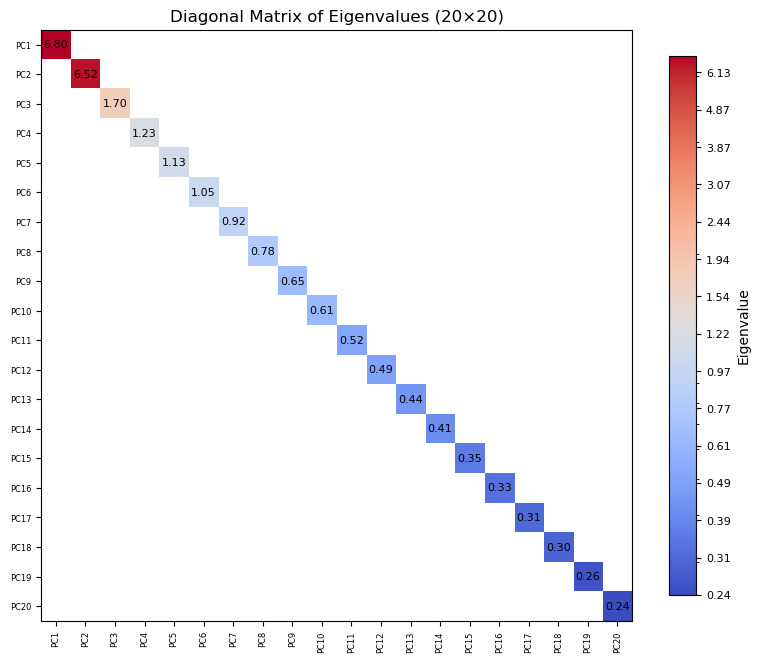

In [70]:
# Plot diagonal matrix of eigenvalues
D = np.diag(eigvals)

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(
    D,
    cmap='coolwarm',
    norm=LogNorm(vmin=eigvals.min(), vmax=eigvals.max())
)

# 1) create tick positions at 10^(log10(min) → log10(max)) stepping by 0.1 in exponent
exp_max = np.log10(eigvals.max())
exp_min = np.log10(eigvals.min())
exp_ticks = np.arange(exp_min, exp_max, 0.1)
tick_positions = 10**exp_ticks
# 2) numeric labels for each tick
tick_labels = [f'{pos:.2f}' for pos in tick_positions]

# 3) add colorbar, shrunk, with custom ticks
cbar = plt.colorbar(im, ax=ax, shrink=0.7, ticks=tick_positions)
cbar.ax.set_yticklabels(tick_labels, fontsize=8)
cbar.set_label('Eigenvalue')

ax.set_title('Diagonal Matrix of Eigenvalues (20×20)')
for i in range(20):
    ax.text(i, i, f'{eigvals[i]:.2f}',
            ha='center', va='center',
            color='black', fontsize=8)

ax.set_xticks(range(20)); ax.set_xticklabels(pc_labels, rotation=90, fontsize=6)
ax.set_yticks(range(20)); ax.set_yticklabels(pc_labels, fontsize=6)
plt.tight_layout()
plt.show()


### Random SST distribution reconstruction using Rank 3 Approximation and Rank 20 Approximation, 82 core locations unchanged

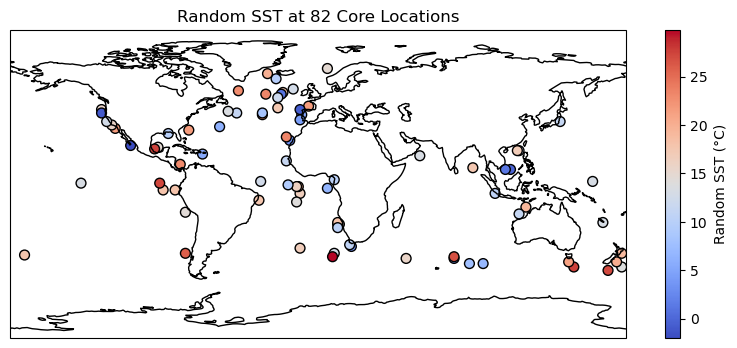

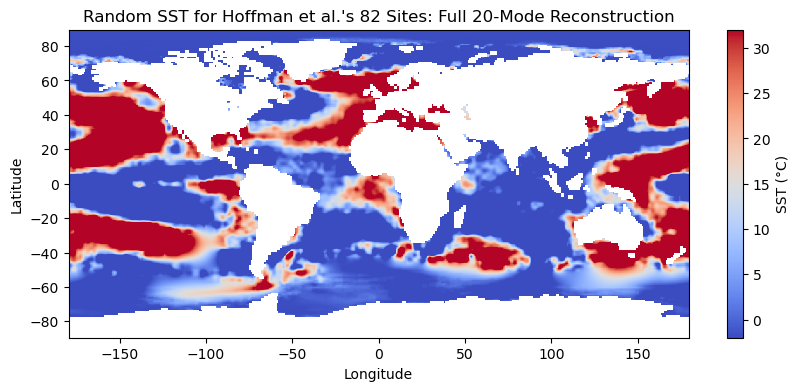

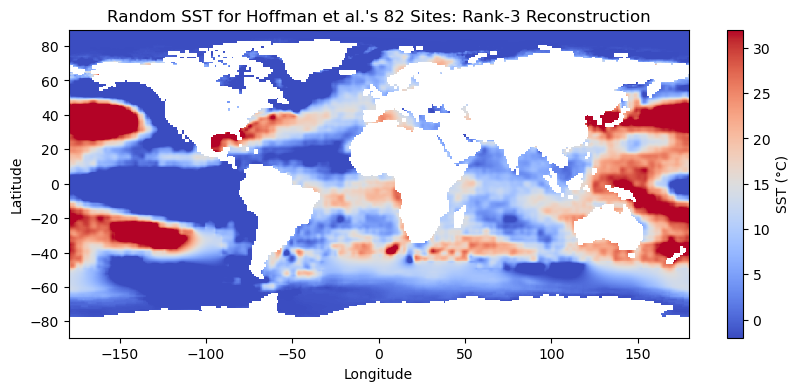

In [54]:
# 1) Build a 82-row table of just the core locations
#    (df_coords has one row per core)
df_rand = df_coords.copy()

# 2) Assign a random SST to each core
np.random.seed(42)
rand_sst = np.random.normal(loc=15, scale=8, size=len(df_rand))
rand_sst = np.clip(rand_sst, -2, 32)
df_rand['sst_rand'] = rand_sst

# 3) Standardize against the global mean/std
std_rand = (df_rand['sst_rand'] - mean_sst) / std_sst

# 4) Predict PC scores from this single 82-vector
#    Note the regressor expects shape (1, 82)
pc_rand = regressor.predict(std_rand.values.reshape(1, -1))[0]  # → length-20

# 5) Full 20-mode reconstruction
recon20_std = pca.inverse_transform(pc_rand.reshape(1, -1))[0]
full_std = np.full(180*360, np.nan)
full_std[valid_indices] = recon20_std
recon20 = full_std.reshape(180, 360) * std_sst + mean_sst

# 6) Rank-3 reconstruction (zero out modes 4–20)
pc_r3 = pc_rand.copy()
pc_r3[3:] = 0
recon3_std = pca.inverse_transform(pc_r3.reshape(1, -1))[0]
full3_std = np.full(180*360, np.nan)
full3_std[valid_indices] = recon3_std
recon3 = full3_std.reshape(180, 360) * std_sst + mean_sst

# 7) Plot the randomly generated SST datapoints and both reconstructed maps

# Random SST datapoints used
fig = plt.figure(figsize=(10,4))
ax  = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())

# draw coastlines (no land fill, so ocean is blank)
ax.add_feature(cfeature.COASTLINE, linewidth=1)

# scatter the 82 points, colored by their random SST
sc = ax.scatter(
    df_rand['longitude'], 
    df_rand['latitude'],
    c=df_rand['sst_rand'],
    cmap='coolwarm',
    s=50,
    edgecolor='k',
    transform=ccrs.PlateCarree()
)

# colorbar
cb = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.05)
cb.set_label('Random SST (°C)')

# labels
ax.set_title('Random SST at 82 Core Locations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

for title, data in [
    ("Random SST for Hoffman et al.'s 82 Sites: Full 20-Mode Reconstruction", recon20),
    ("Random SST for Hoffman et al.'s 82 Sites: Rank-3 Reconstruction",       recon3),
]:
    fig, ax = plt.subplots(figsize=(10,4))
    im = ax.imshow(
        data,
        origin='lower',
        extent=extent,
        aspect='auto',
        cmap='coolwarm',
        vmin=-2, vmax=32
    )
    ax.set_title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    cb = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05)
    cb.set_label('SST (°C)')
    plt.show()

### Deepseek updated version with 100-yr averaged EOF

Using all 8200 samples for training

=== 1870 Analysis ===
First 3 PCs: [-2.8664627 -1.2080116  1.0285683]


TypeError: unsupported operand type(s) for -: 'float' and 'method'

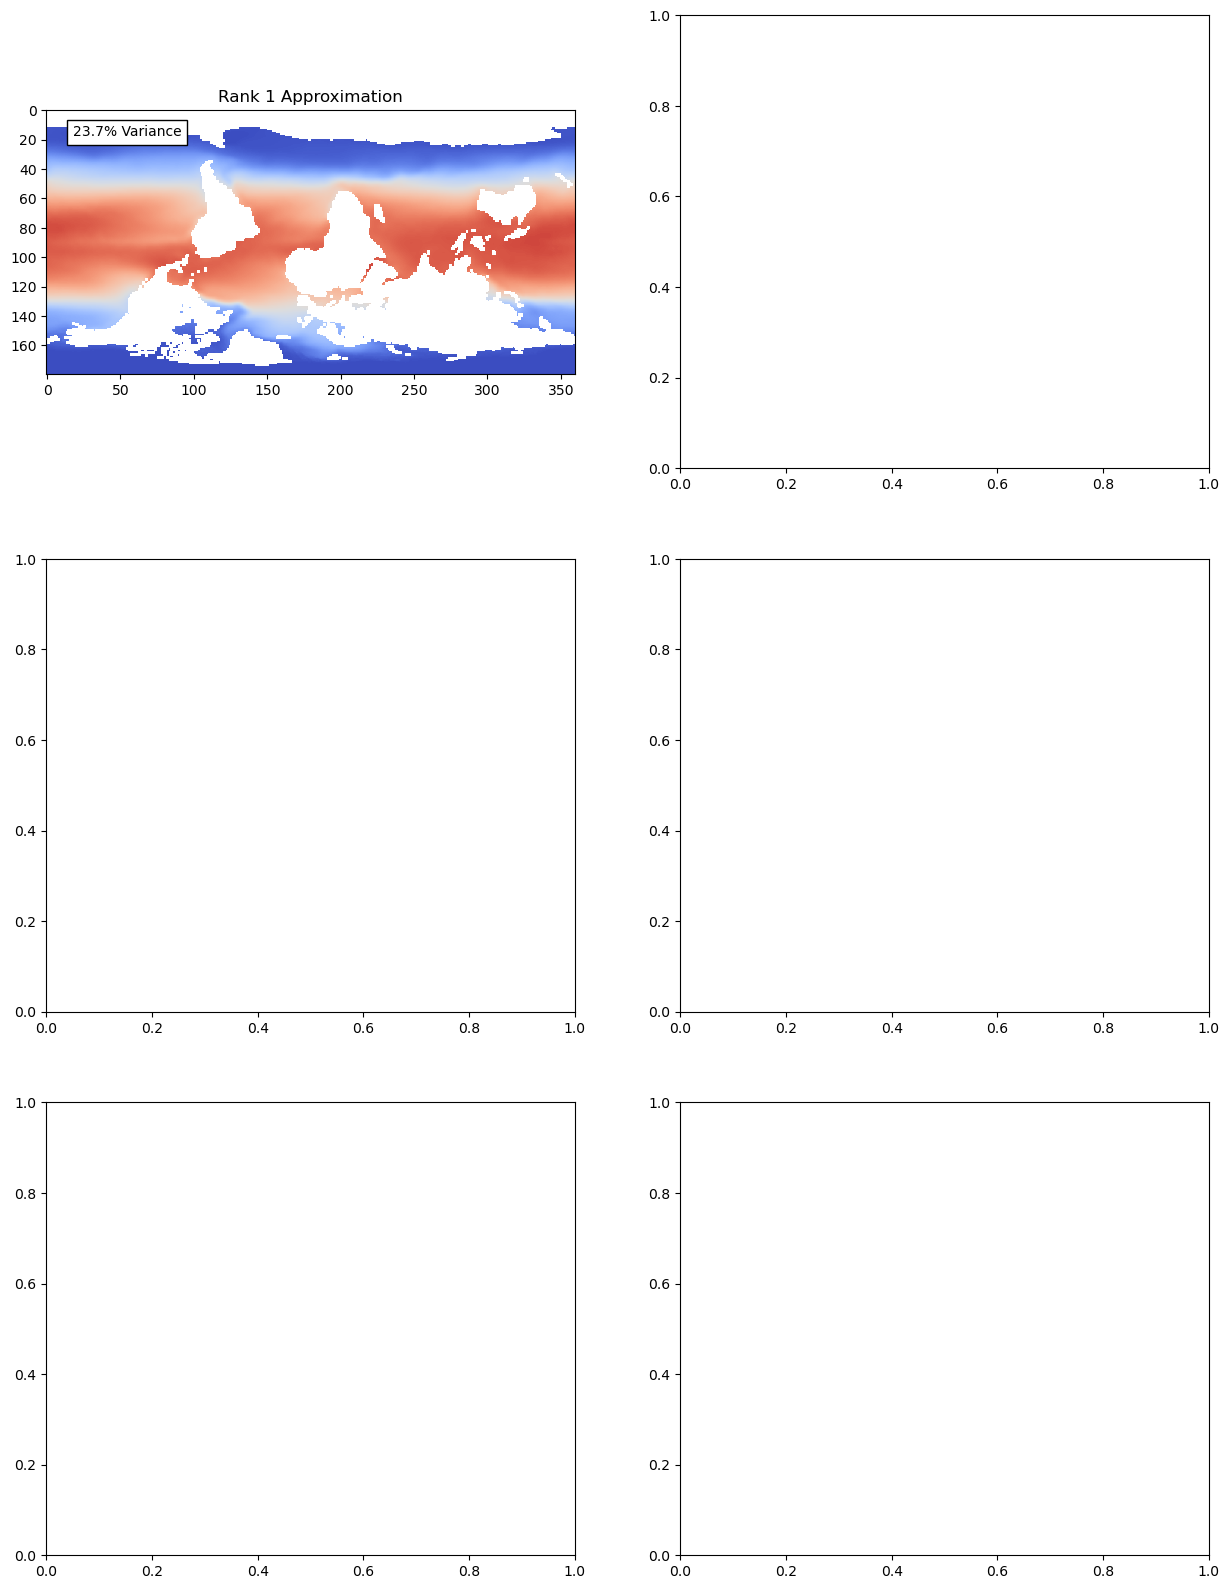

In [25]:
# Modified EOF Analysis Section ===============================================

# Remove time-based split - use all data
train_df = df_subset.copy()
print("Using all", len(train_df), "samples for training")

# Step 1: Standardize using global data statistics
valid_sst = df_global['annual_sst'].dropna()
train_mean = valid_sst.mean()
train_std = valid_sst.std()

# Step 2: Prepare PCA matrix with imputation (using all years)
pca_matrix = df_global['sst_std'].values.reshape(-1, 180*360)[:, valid_indices]
pca_matrix_imputed = imputer.fit_transform(pca_matrix)

# Step 3: Perform PCA on full dataset
n_components = 20
pca = PCA(n_components=n_components)
pc_scores_full = pca.fit_transform(pca_matrix_imputed)

# Get averaged principal components (100-year mean)
mean_pc_scores = pc_scores_full.mean(axis=0)

# Step 4: Prepare full training data
full_pivot = train_df.pivot(index='year', 
                           columns=['latitude','longitude'], 
                           values='sst_std').fillna(0)

# Step 5: Train robust regression model
regressor = LinearRegression()
regressor.fit(full_pivot.values, pc_scores_full)

# Reconstruction function with rank control
def reconstruct_sst_map(input_values, rank=None):
    """Reconstruct with specified PC rank"""
    std_values = (input_values - train_mean)/train_std
    pc_pred = regressor.predict([std_values])
    
    if rank is not None:
        pc_pred[:, rank:] = 0  # Zero out higher components
        
    recon_std = pca.inverse_transform(pc_pred)[0]
    full_grid = np.full(180*360, np.nan)
    full_grid[valid_indices] = recon_std * train_std + train_mean
    return full_grid.reshape(180, 360)

# Generate outputs for target years
for target_year in [1870, 1969]:
    print(f"\n=== {target_year} Analysis ===")
    
    # Get core data
    year_data = train_df[train_df['year'] == target_year]
    input_values = year_data['annual_sst'].values
    
    # 1. Show first 3 PCs
    pc_scores = regressor.predict([(input_values-train_mean)/train_std])
    print(f"First 3 PCs: {pc_scores[0,:3]}")
    
    # 2-5. Generate reconstructions and anomalies
    fig, axs = plt.subplots(3, 2, figsize=(15, 20))
    
    for i, rank in enumerate([1, 2, 3]):
        # Rank approximation
        recon_map = reconstruct_sst_map(input_values, rank=rank)
        real_map = HadISST_annual_ds.sel(year=target_year).values
        
        # 2. Rank approximation plot
        axs[i,0].imshow(recon_map, cmap='coolwarm', vmin=-2, vmax=32)
        axs[i,0].set_title(f'Rank {rank} Approximation')
        
        # 3. Confidence level
        var_exp = pca.explained_variance_ratio_[:rank].sum()*100
        axs[i,0].text(0.05,0.9, f'{var_exp:.1f}% Variance', 
                      transform=axs[i,0].transAxes, 
                      bbox=dict(facecolor='white'))
        
        # 5. Anomaly plot
        anomaly = recon_map - real_map
        im = axs[i,1].imshow(anomaly, cmap='coolwarm', vmin=-2, vmax=2)
        plt.colorbar(im, ax=axs[i,1])
        axs[i,1].set_title(f'Rank {rank} Anomaly')
    
    # 4. Full reconstruction
    full_recon = reconstruct_sst_map(input_values)
    full_anomaly = full_recon - real_map
    
    # Add full reconstruction plots
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(full_recon, cmap='coolwarm', vmin=-2, vmax=32)
    plt.title('Full Reconstruction')
    
    plt.subplot(122)
    plt.imshow(full_anomaly, cmap='coolwarm', vmin=-2, vmax=2)
    plt.colorbar()
    plt.title('Full Anomaly')
    
    plt.suptitle(f'{target_year} Complete Reconstruction')
    plt.show()

# Final diagnostics
print("PCA Variance Ratios:", pca.explained_variance_ratio_)

## Old EOF with year-by-year PCA

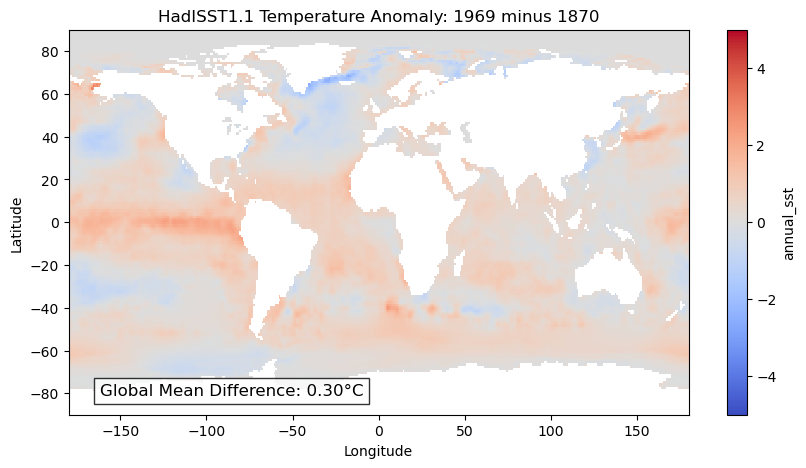

In [5]:
# Select the first (1870) and last (1969) annual SST layers
sst_1870 = HadISST_annual_ds.annual_sst.sel(year=1870)
sst_1969 = HadISST_annual_ds.annual_sst.sel(year=1969)

# Compute the SST anomaly: difference between 1969 and 1870
sst_anomaly = sst_1969 - sst_1870

# Plot the SST anomaly using the coolwarm colormap
fig, ax = plt.subplots(figsize=(10, 5))
sst_anomaly.plot(
    ax=ax,
    vmin=-5,
    vmax=5,
    cmap='coolwarm',
    add_colorbar=True
)

# Add mean difference
anomaly_mean = sst_anomaly.mean().values
plt.text(0.05, 0.05, 
        f'Global Mean Difference: {anomaly_mean:.2f}°C',
        transform=plt.gca().transAxes,
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.8))

ax.set_title("HadISST1.1 Temperature Anomaly: 1969 minus 1870")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [6]:
# Convert to a Dataset with variable name 'annual_sst'
HadISST_annual_ds = HadISST_annual.to_dataset(name='annual_sst')
print(HadISST_annual_ds)

# Convert the full annual dataset to a DataFrame.
df_global = HadISST_annual_ds.annual_sst.to_dataframe().reset_index()

# Merge with exact coordinate matching
df_subset = pd.merge(df_global, df_coords, on=['latitude', 'longitude'], how='inner')
print("After merging with df_coords, total grid points =", df_subset.shape[0])

# Filter land/sea ice grids
df_subset = df_subset[df_subset['annual_sst'] > -1.8]
print("After filtering land/sea ice, grid points =", df_subset.shape[0])

# --- Create a time–based split ---
# Training data: years that are NOT multiples of 5.
# Testing data: years that ARE multiples of 5.
train_df = df_subset[df_subset['year'] % 5 != 0]
test_df  = df_subset[df_subset['year'] % 5 == 0]

print("Number of training samples:", train_df.shape[0])
print("Number of testing samples:", test_df.shape[0])
if train_df.shape[0] == 0:
    raise ValueError("Training dataset is empty! Check the merge and filtering steps.")

<xarray.Dataset>
Dimensions:     (latitude: 180, longitude: 360, year: 100)
Coordinates:
  * latitude    (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude   (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * year        (year) int64 1870 1871 1872 1873 1874 ... 1966 1967 1968 1969
Data variables:
    annual_sst  (year, latitude, longitude) float32 -1.8 -1.8 -1.8 ... nan nan
After merging with df_coords, total grid points = 8200
After filtering land/sea ice, grid points = 8200
Number of training samples: 6560
Number of testing samples: 1640


### From Deepseek: EOF (PCA)

In [7]:
# Step 1: Standardize using global data statistics
valid_sst = df_global['annual_sst'].dropna()
train_mean = valid_sst.mean()
train_std = valid_sst.std()

# Use copy() to avoid SettingWithCopyWarning
df_global = df_global.copy()
train_df = train_df.copy()
test_df = test_df.copy()

for df in [df_global, train_df, test_df]:
    df['sst_std'] = (df['annual_sst'] - train_mean) / train_std

# Step 2: Prepare PCA matrix with imputation
# Create valid ocean mask (grids with data in ANY year)
valid_mask = (~df_global['annual_sst'].isnull()).values.reshape(-1, 180, 360).any(axis=0)
valid_indices = np.where(valid_mask.ravel())[0]

# Create PCA matrix and impute missing values
pca_matrix = df_global['sst_std'].values.reshape(-1, 180*360)[:, valid_indices]

# Impute NaN values with temporal mean for each grid point
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
pca_matrix_imputed = imputer.fit_transform(pca_matrix)

# Step 3: Perform PCA on imputed data
n_components = 20
pca = PCA(n_components=n_components)
pc_scores = pca.fit_transform(pca_matrix_imputed)

# Step 4: Prepare training data for regression model
# Create pivot table for 82-point inputs
train_pivot = train_df.pivot(index='year', 
                            columns=['latitude', 'longitude'], 
                            values='sst_std')

# Find nearest grid indices using vectorized operations
lats = HadISST_annual_ds.latitude.values
lons = HadISST_annual_ds.longitude.values

def find_nearest_index(target, array):
    """Find index of nearest value in array"""
    return np.abs(array - target).argmin()

grid_points = []
for lat, lon in df_coords[['latitude', 'longitude']].values:
    # Find nearest latitude index
    lat_idx = find_nearest_index(lat, lats)
    # Find nearest longitude index
    lon_idx = find_nearest_index(lon, lons)
    grid_points.append(lat_idx * 360 + lon_idx)

# Step 5: Train regression model
regressor = LinearRegression()
X_train = train_pivot.values
y_train = pc_scores[[np.where(HadISST_annual_ds.year.values == yr)[0][0] 
                   for yr in train_pivot.index]]
regressor.fit(X_train, y_train)

# Step 6: Update reconstruction function with imputation
def reconstruct_sst_map(input_values):
    """Reconstruct full SST map from 82 input values"""
    # Standardize input using TRAINING statistics
    std_values = (input_values - train_mean) / train_std
    
    # Predict PC scores
    pc_pred = regressor.predict([std_values])
    
    # Reconstruct standardized grid WITH IMPUTATION
    recon_std = pca.inverse_transform(pc_pred)[0]
    
    # Create full grid with original NaN patterns
    full_grid = np.full(180*360, np.nan)
    full_grid[valid_indices] = recon_std
    
    # Un-standardize and reshape
    return full_grid.reshape(180, 360) * train_std + train_mean

# Step 7: Generate predictions for all training years
reconstructed_maps = []
for yr in train_df['year'].unique():
    year_data = train_df[train_df['year'] == yr]
    input_values = year_data['annual_sst'].values
    recon_map = reconstruct_sst_map(input_values)
    reconstructed_maps.append((yr, recon_map))

# Convert to xarray Dataset for easy handling
reconstructed_ds = xr.Dataset(
    data_vars={
        'annual_sst': (('year', 'latitude', 'longitude'), 
                      np.array([rm[1] for rm in reconstructed_maps]))
    },
    coords={
        'year': [rm[0] for rm in reconstructed_maps],
        'latitude': HadISST_annual_ds.latitude.values,
        'longitude': HadISST_annual_ds.longitude.values
    }
)

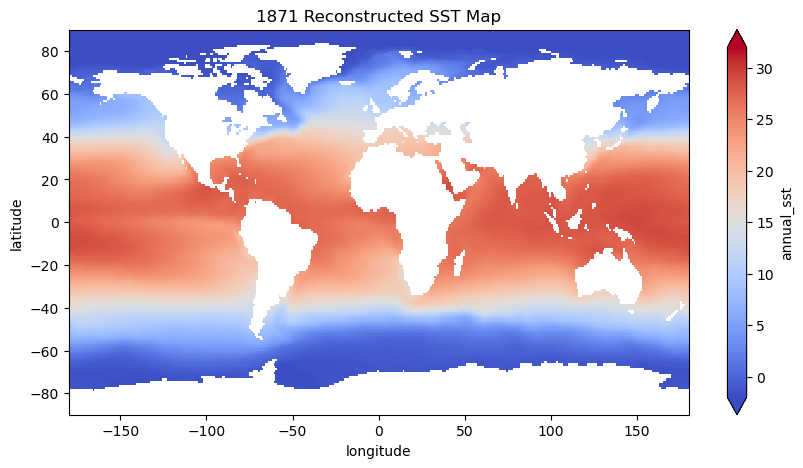

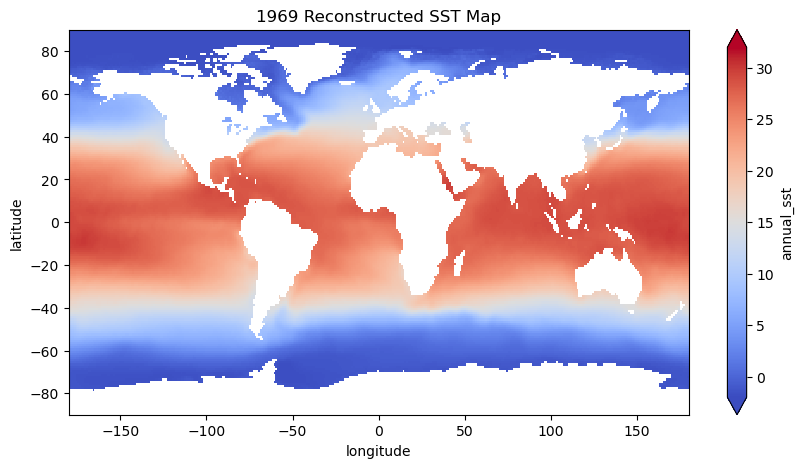

In [8]:
# Plotting reconstructed map
for yr in [1871, 1969]:
    fig, ax = plt.subplots(figsize=(10, 5))
    im = reconstructed_ds.annual_sst.sel(year=yr).plot(
        ax=ax, cmap='coolwarm', vmin=-2, vmax=32, extend='both'
    )
    
    ax.set_title(f'{yr} Reconstructed SST Map')
    
    plt.show()

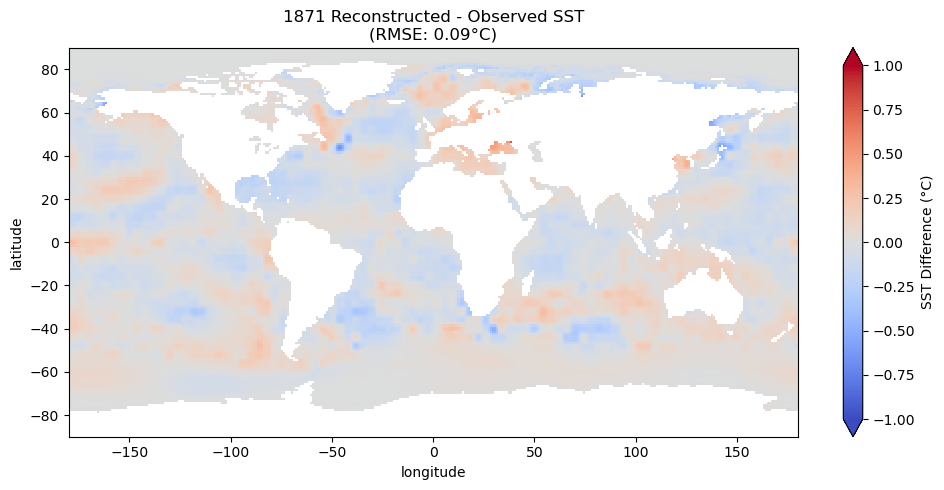

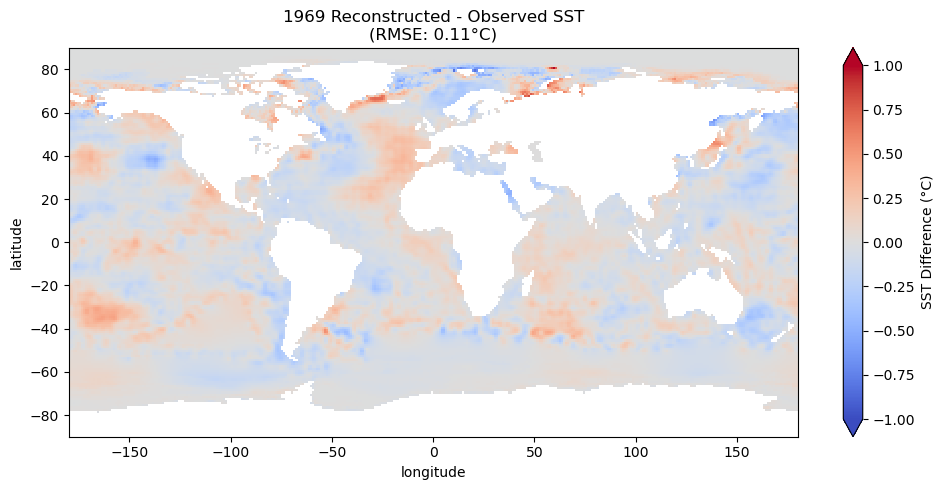

In [9]:
# Convert df_global to xarray Dataset for easy comparison
real_ds = df_global.set_index(['year', 'latitude', 'longitude']).to_xarray().annual_sst

# Plotting function for difference maps
def plot_difference(year, reconstructed_ds, real_ds):
    """Plot reconstructed - real SST difference for a given year"""
    plt.figure(figsize=(10, 5))
    diff = reconstructed_ds.sel(year=year) - real_ds.sel(year=year)
    
    # Plot with centered colormap
    im = diff.plot(cmap='coolwarm', 
                  center=0, 
                  vmin=-1, vmax=1,
                  add_colorbar=False)
    
    # Add colorbar and title
    plt.colorbar(im, label='SST Difference (°C)', extend='both')
    plt.title(f'{year} Reconstructed - Observed SST\n(RMSE: {diff.std().values:.2f}°C)')
    plt.tight_layout()
    plt.show()

# Plot 1871 difference (first figure)
plot_difference(1871, reconstructed_ds.annual_sst, real_ds)

# Plot 1969 difference (second figure)
plot_difference(1969, reconstructed_ds.annual_sst, real_ds)

In [10]:
# Step 8: Test reconstruction on validation years (multiples of 5)
# Prepare test data pivot table
test_pivot = test_df.pivot(index='year', 
                          columns=['latitude', 'longitude'], 
                          values='sst_std')

# Reconstruct maps for test years
test_reconstructions = []
for yr in test_df['year'].unique():
    year_data = test_df[test_df['year'] == yr]
    input_values = year_data['annual_sst'].values
    recon_map = reconstruct_sst_map(input_values)
    test_reconstructions.append((yr, recon_map))

# Convert test reconstructions to xarray
test_reconstructed_ds = xr.Dataset(
    data_vars={
        'annual_sst': (('year', 'latitude', 'longitude'), 
                     np.array([tr[1] for tr in test_reconstructions]))
    },
    coords={
        'year': [tr[0] for tr in test_reconstructions],
        'latitude': HadISST_annual_ds.latitude.values,
        'longitude': HadISST_annual_ds.longitude.values
    }
)

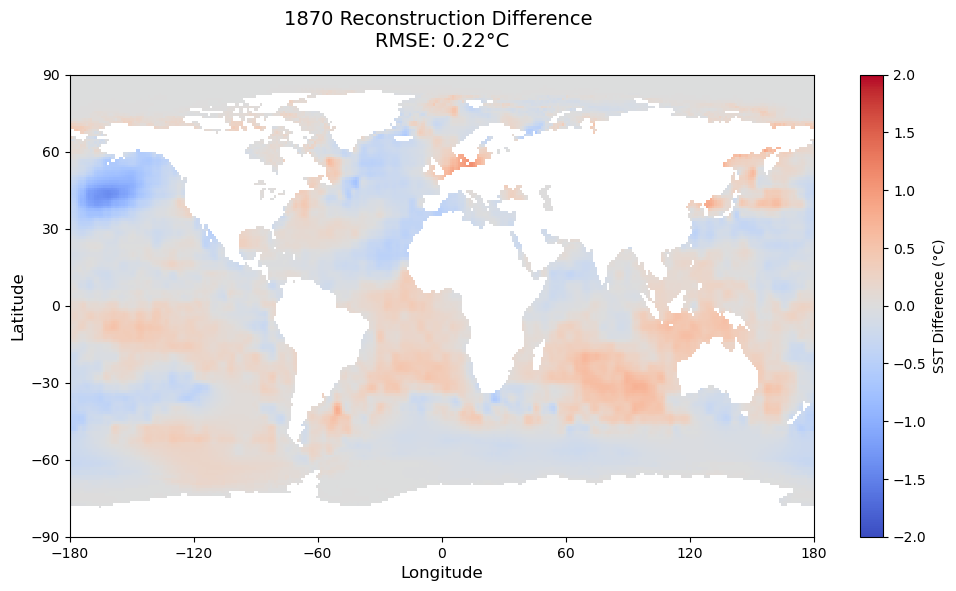

In [12]:
# Calculate and plot 1870 difference
diff_1870 = test_reconstructed_ds.sel(year=1870).annual_sst - real_ds.sel(year=1870)

plt.figure(figsize=(12, 6))

# Create basic plot with xarray's built-in coordinates
diff_1870.plot(cmap='coolwarm', 
              center=0,
              vmin=-2, 
              vmax=2,
              cbar_kwargs={'label': 'SST Difference (°C)'})

# Force longitude/latitude ticks
plt.xticks(np.arange(-180, 181, 60))
plt.yticks(np.arange(-90, 91, 30))

# Add RMSE to title
rmse = np.sqrt((diff_1870**2).mean().values)
plt.title(f"1870 Reconstruction Difference \nRMSE: {rmse:.2f}°C", 
         fontsize=14, pad=20)

plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.show()

In [13]:
# Merge training and test reconstructions
merged_reconstructed_ds = xr.concat(
    [reconstructed_ds, test_reconstructed_ds], 
    dim='year'
).sortby('year')

# Verify the merge
print("Merged dataset years:", merged_reconstructed_ds.year.values)
print("Total years:", len(merged_reconstructed_ds.year))

# Example usage: Access any year's reconstruction
year_1870 = merged_reconstructed_ds.sel(year=1870)
year_1969 = merged_reconstructed_ds.sel(year=1969)

# Full dataset structure
print("\nMerged dataset structure:")
print(merged_reconstructed_ds)

Merged dataset years: [1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883
 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897
 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911
 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925
 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939
 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953
 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967
 1968 1969]
Total years: 100

Merged dataset structure:
<xarray.Dataset>
Dimensions:     (year: 100, latitude: 180, longitude: 360)
Coordinates:
  * year        (year) int64 1870 1871 1872 1873 1874 ... 1966 1967 1968 1969
  * latitude    (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude   (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    annual_sst  (year, latitude, longitude) float64 -1.8 -1.8 -1.8 ... nan nan


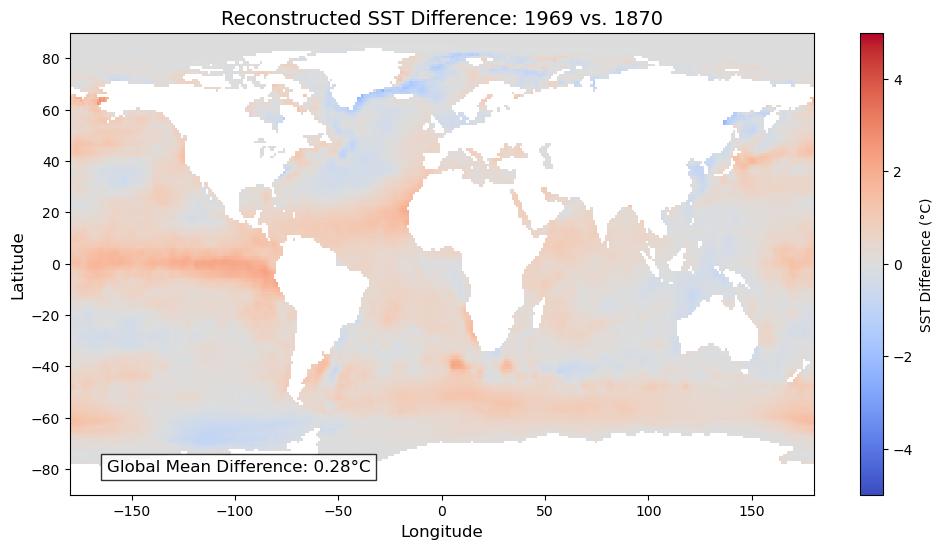

In [14]:
# Calculate the SST anomaly between 1969 and 1870 reconstructions
anomaly = (
    merged_reconstructed_ds.annual_sst.sel(year=1969) 
    - merged_reconstructed_ds.annual_sst.sel(year=1870)
)

# Create plot
plt.figure(figsize=(12, 6))

# Plot anomaly with focused color range
anomaly.plot(cmap='coolwarm',
            center=0,
            vmin=-5, 
            vmax=5,
            cbar_kwargs={'label': 'SST Difference (°C)'})

# Add plot decorations
plt.title('Reconstructed SST Difference: 1969 vs. 1870', fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Add statistical annotation
mean_diff = anomaly.mean().values
plt.text(0.05, 0.05, 
        f'Global Mean Difference: {mean_diff:.2f}°C',
        transform=plt.gca().transAxes,
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.8))

plt.show()

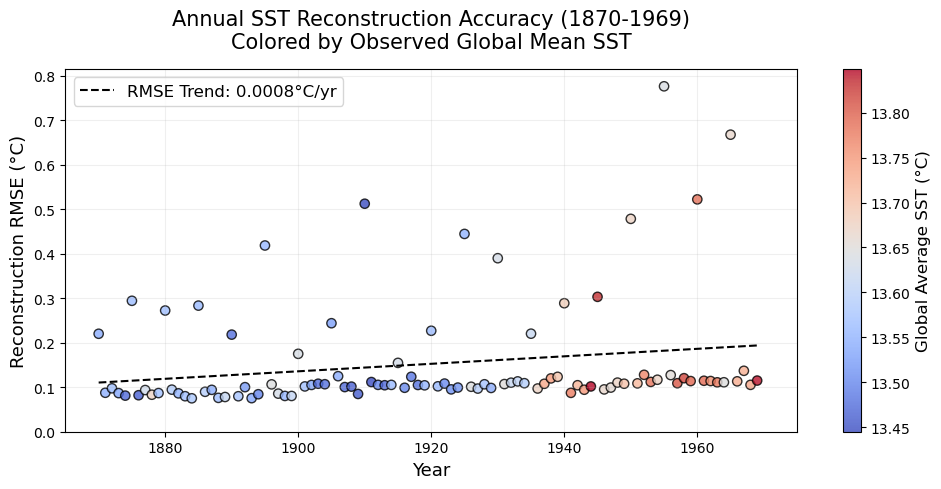

In [15]:
# Calculate annual RMSE and average SST for ALL YEARS
all_years = merged_reconstructed_ds.year.values
rmse_values = []
avg_sst_values = []

for year in all_years:
    # Calculate difference map using merged reconstructions
    diff = merged_reconstructed_ds.sel(year=year).annual_sst - real_ds.sel(year=year)
    
    # Compute RMSE (ocean grids only)
    squared_diff = diff.where(~np.isnan(diff)).values**2
    rmse_values.append(np.sqrt(np.nanmean(squared_diff)))
    
    # Compute global average SST (observed)
    avg_sst = real_ds.sel(year=year).mean().values
    avg_sst_values.append(avg_sst)

# Create figure
plt.figure(figsize=(10, 5))

# Scatter plot colored by average SST
sc = plt.scatter(all_years, rmse_values, c=avg_sst_values, 
                cmap='coolwarm', edgecolor='k', alpha=0.8, s=45,
                vmin=np.min(avg_sst_values), vmax=np.max(avg_sst_values))

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Global Average SST (°C)', fontsize=12)

# Add trend line for RMSE
z = np.polyfit(all_years, rmse_values, 1)
p = np.poly1d(z)
plt.plot(all_years, p(all_years), 'k--', 
        label=f'RMSE Trend: {z[0]:.4f}°C/yr')

# Formatting
plt.xlabel('Year', fontsize=13)
plt.ylabel('Reconstruction RMSE (°C)', fontsize=13)
plt.title('Annual SST Reconstruction Accuracy (1870-1969)\nColored by Observed Global Mean SST', 
         fontsize=15, pad=15)
plt.grid(alpha=0.2)
plt.legend(fontsize=12)

# Set axis limits
plt.xlim(1865, 1975)
plt.ylim(0, max(rmse_values)*1.05)

plt.tight_layout()
plt.show()

### Century averaged EOFc

In [55]:
# 1. Create century-average from df_subset (86 grids)
century_avg = (
    df_subset[(df_subset['year'] >= 1870) & (df_subset['year'] <= 1970)]
    .groupby(['latitude', 'longitude'])['annual_sst']
    .mean()
    .reset_index()
)

# Verify we have all 86 grids
assert len(century_avg) == 86, "Missing grid points in century average"

# 2. Handle NaNs (if any remain after filtering)
from sklearn.impute import SimpleImputer

# Impute any missing values with column mean
imputer = SimpleImputer(strategy='mean')
X_century = imputer.fit_transform(century_avg[['annual_sst']].values.reshape(1, -1))

# Standardize using original training stats
X_century_std = (X_century - train_mean) / train_std

# Predict and reconstruct
pc_scores_century = regressor.predict(X_century_std)
recon_century = pca.inverse_transform(pc_scores_century)[0]

# Create full grid map
full_grid = np.full(180*360, np.nan)
full_grid[valid_indices] = recon_century * train_std + train_mean
recon_century_map = full_grid.reshape(180, 360)

# Plot
plt.figure(figsize=(10,5))
plt.imshow(recon_century_map, cmap='coolwarm', 
           extent=[-180,180,-90,90], vmin=-2, vmax=30)
plt.colorbar(label='SST (°C)')
plt.title('Century-Averaged Reconstructed SST (1870-1970)')
plt.show()

# 3. Create observed century-average map
obs_century = (
    df_global[(df_global['year'] >= 1870) & (df_global['year'] <= 1970)]
    .groupby(['latitude', 'longitude'])['annual_sst']
    .mean()
    .reset_index()
    .rename(columns={'annual_sst': 'observed_sst'})
)

# Merge with reconstructed data
century_comparison = pd.merge(century_avg, obs_century, 
                             on=['latitude', 'longitude'])

# 4. Analyze anomalies
# Century-scale anomaly
century_diff = recon_century_map - obs_century.set_index(['latitude', 'longitude']).to_xarray().observed_sst.values

# Individual year anomalies
def get_year_anomaly(year):
    recon = merged_reconstructed_ds.sel(year=year).annual_sst.values
    obs = real_ds.sel(year=year).values
    return recon - obs

diff_1870 = get_year_anomaly(1870)
diff_1970 = get_year_anomaly(1970)

# Calculate RMSEs
rmse_century = np.sqrt(np.nanmean(century_diff**2))
rmse_1870 = np.sqrt(np.nanmean(diff_1870**2))
rmse_1970 = np.sqrt(np.nanmean(diff_1970**2))

print(f'''Reconstruction Errors:
- Century Average (1870-1970): {rmse_century:.2f}°C
- Single Year 1870: {rmse_1870:.2f}°C
- Single Year 1970: {rmse_1970:.2f}°C''')

# Visualization of century anomaly
plt.figure(figsize=(10,5))
plt.imshow(century_diff, cmap='coolwarm', 
          extent=[-180,180,-90,90], vmin=-1, vmax=1)
plt.colorbar(label='SST Anomaly (°C)')
plt.title('Century Reconstruction Anomaly (Reconstructed - Observed)')
plt.show()

AssertionError: Missing grid points in century average

In [61]:
# 1. Create century-average of 86 locations (1870-1970)
century_avg = (
    df_global[(df_global['year'] >= 1870) & (df_global['year'] <= 1970)]
    .groupby(['latitude', 'longitude'])['annual_sst']
    .mean()
    .reset_index()
)
century_avg.rename(columns={'annual_sst': 'reconstructed_sst'}, inplace=True)

# 2. Reconstruct global map using existing EOF model
# Prepare input (single "year" of averaged values)
X_century = century_avg['reconstructed_sst'].values.reshape(1, -1)

# Standardize using original global stats
X_century_std = (X_century - train_mean) / train_std


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### From ChatGPT: EOF (PCA)

In [29]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# --- A) Pivot the 86‐point core data into one row per year ----
#   train_df has columns ['year','latitude','longitude','annual_sst']
train_pivot = (
    train_df
    .pivot(index='year', columns=['latitude','longitude'], values='annual_sst')
    # sort the columns so we keep a consistent order of the 86 cores
    .reindex(sorted(train_df[['latitude','longitude']].drop_duplicates().itertuples(index=False, name=None)),
             axis=1)
)
# rename the 86 columns to simple labels
train_pivot.columns = [f"core_{i}" for i in range(train_pivot.shape[1])]
train_pivot = train_pivot.reset_index()   # now columns = ['year','core_0',…,'core_85']

# --- B) Build the regression dataset by merging with df_global ----
# 1) global training rows (all ocean cells in train years)
global_train = df_global[df_global['year'] % 5 != 0].copy()
global_test  = df_global[df_global['year'] % 5 == 0].copy()

# 2) merge so each global row carries along the 86 core values for that year
train_merged = pd.merge(global_train, train_pivot, on='year', how='left')
test_merged  = pd.merge(global_test,  train_pivot, on='year', how='left')

# 3) drop any rows where the join failed (i.e. missing core data)
train_merged = train_merged.dropna(subset=[f"core_{i}" for i in range(86)])
test_merged  = test_merged .dropna(subset=[f"core_{i}" for i in range(86)])

# --- C) Extract X, y for train & test ----
feature_cols = ['year','longitude','latitude'] + [f"core_{i}" for i in range(86)]

X_train = train_merged[feature_cols].values
y_train = train_merged['annual_sst'].values

X_test  = test_merged[feature_cols].values
y_test  = test_merged['annual_sst'].values

# --- D) Scale features, fit Ridge ----
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

reg = Ridge(alpha=1.0)
reg.fit(X_train_scaled, y_train)

# quick eval on held‐out
y_pred = reg.predict(X_test_scaled)
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# --- E) Reconstruct full global maps for each test year ----
# attach predictions
test_merged['sst_pred'] = y_pred

# loop over test years and pivot back to 2D maps
for yr in np.sort(test_merged['year'].unique()):
    sub = test_merged[test_merged['year']==yr]
    # pivot returns a (lat × lon) DataFrame of predictions
    grid_pred = sub.pivot(index='latitude', columns='longitude', values='sst_pred')

    # plot
    fig, ax = plt.subplots(1,1, figsize=(8,4), subplot_kw={'projection': ccrs.PlateCarree()})
    pcm = ax.pcolormesh(
        grid_pred.columns, grid_pred.index, grid_pred.values,
        cmap='coolwarm', vmin=-2, vmax=32,
        transform=ccrs.PlateCarree()
    )
    ax.coastlines()
    ax.set_title(f"Interpolated SST (Ridge) for {yr}")
    plt.colorbar(pcm, ax=ax, orientation='horizontal', pad=0.05)
    plt.show()


KeyError: ['core_24', 'core_25', 'core_26', 'core_27', 'core_28', 'core_29', 'core_30', 'core_31', 'core_32', 'core_33', 'core_34', 'core_35', 'core_36', 'core_37', 'core_38', 'core_39', 'core_40', 'core_41', 'core_42', 'core_43', 'core_44', 'core_45', 'core_46', 'core_47', 'core_48', 'core_49', 'core_50', 'core_51', 'core_52', 'core_53', 'core_54', 'core_55', 'core_56', 'core_57', 'core_58', 'core_59', 'core_60', 'core_61', 'core_62', 'core_63', 'core_64', 'core_65', 'core_66', 'core_67', 'core_68', 'core_69', 'core_70', 'core_71', 'core_72', 'core_73', 'core_74', 'core_75', 'core_76', 'core_77', 'core_78', 'core_79', 'core_80', 'core_81', 'core_82', 'core_83', 'core_84', 'core_85']

reconstructed_ds### From Deepseek: CNN

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate, BatchNormalization, Activation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. Standardize the SST values
scaler = StandardScaler()

# Fit scaler on all available ocean SST data (excluding NaNs)
all_sst = df_global['annual_sst'].dropna().values.reshape(-1, 1)
scaler.fit(all_sst)

# Apply standardization to all datasets
df_global['annual_sst_std'] = scaler.transform(df_global[['annual_sst']].values)
train_df['annual_sst_std'] = scaler.transform(train_df[['annual_sst']].values)
test_df['annual_sst_std'] = scaler.transform(test_df[['annual_sst']].values)

# 2. Prepare the data for CNN training

# Create a mask for ocean pixels (where SST is not NaN)
ocean_mask = ~np.isnan(HadISST_annual_ds.annual_sst.isel(year=0).values)

# Function to create sparse input maps from the 86 points
def create_sparse_input(year_data, df_coords):
    sparse_map = np.full((180, 360), np.nan)
    for _, row in df_coords.iterrows():
        lat_idx = np.where(HadISST_annual_ds.latitude.values == row['latitude'])[0][0]
        lon_idx = np.where(HadISST_annual_ds.longitude.values == row['longitude'])[0][0]
        # Find the SST value for this location in the given year
        sst_value = year_data[(year_data['latitude'] == row['latitude']) & 
                              (year_data['longitude'] == row['longitude'])]['annual_sst_std'].values
        if len(sst_value) > 0:
            sparse_map[lat_idx, lon_idx] = sst_value[0]
    # Replace remaining NaNs with 0 (will be masked later)
    sparse_map = np.nan_to_num(sparse_map, nan=0)
    return sparse_map

# Prepare training data
X_train = []
y_train = []

for year in train_df['year'].unique():
    year_data = train_df[train_df['year'] == year]
    # Create sparse input (86 points)
    sparse_input = create_sparse_input(year_data, df_coords)
    # Get full target map for this year
    full_map = HadISST_annual_ds.sel(year=year)['annual_sst_std'].values
    full_map = np.nan_to_num(full_map, nan=0)  # Replace NaNs with 0
    
    X_train.append(sparse_input)
    y_train.append(full_map)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Add channel dimension
X_train = X_train[..., np.newaxis]
y_train = y_train[..., np.newaxis]

# Create ocean mask tensor (will be used in loss function)
ocean_mask_tensor = ocean_mask.astype(np.float32)[np.newaxis, ..., np.newaxis]

# 3. Build the CNN model

def build_interpolation_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(64, (5, 5), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    # Bottleneck
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    # Final layer
    outputs = Conv2D(1, (3, 3), activation='linear', padding='same')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = build_interpolation_model((180, 360, 1))
model.summary()

# Custom loss function that only considers ocean pixels
def ocean_mse_loss(y_true, y_pred):
    # Calculate squared error
    squared_error = tf.square(y_true - y_pred)
    # Apply ocean mask (only count errors where ocean_mask_tensor == 1)
    masked_error = squared_error * ocean_mask_tensor
    return tf.reduce_mean(masked_error)

# Compile the model
model.compile(optimizer='adam', loss=ocean_mse_loss)

# 4. Train the model
history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=50,
    validation_split=0.2,
    verbose=1
)

# 5. Prepare test data and evaluate
X_test = []
y_test = []
test_years = []

for year in test_df['year'].unique():
    year_data = test_df[test_df['year'] == year]
    sparse_input = create_sparse_input(year_data, df_coords)
    full_map = HadISST_annual_ds.sel(year=year)['annual_sst_std'].values
    full_map = np.nan_to_num(full_map, nan=0)
    
    X_test.append(sparse_input)
    y_test.append(full_map)
    test_years.append(year)

X_test = np.array(X_test)[..., np.newaxis]
y_test = np.array(y_test)[..., np.newaxis]

# Evaluate on test data
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE on ocean pixels): {test_loss:.4f}")

# 6. Function to predict full map from sparse inputs
def predict_full_sst_map(sparse_inputs, model, scaler):
    # Standardize inputs if not already done
    if isinstance(sparse_inputs, pd.DataFrame):
        sparse_inputs['annual_sst_std'] = scaler.transform(sparse_inputs[['annual_sst']].values)
        sparse_map = create_sparse_input(sparse_inputs, df_coords)
    else:
        sparse_map = sparse_inputs
    
    # Add batch and channel dimensions
    sparse_map = np.expand_dims(sparse_map[np.newaxis, ..., np.newaxis], axis=0)
    
    # Predict
    predicted_map_std = model.predict(sparse_map)[0,...,0]
    
    # Inverse transform to get original scale
    predicted_map = scaler.inverse_transform(predicted_map_std.reshape(-1, 1)).reshape(180, 360)
    
    # Apply ocean mask (set land to NaN)
    predicted_map[~ocean_mask] = np.nan
    
    return predicted_map

# Example usage on a test year
example_year = test_years[0]
example_data = test_df[test_df['year'] == example_year]
predicted_map = predict_full_sst_map(example_data, model, scaler)

# Compare with true map
true_map = HadISST_annual_ds.sel(year=example_year)['annual_sst'].values

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
true_map_plot = ax1.imshow(true_map, cmap='coolwarm', vmin=-2, vmax=32)
ax1.set_title(f"True SST Map {example_year}")
fig.colorbar(true_map_plot, ax=ax1)

pred_map_plot = ax2.imshow(predicted_map, cmap='coolwarm', vmin=-2, vmax=32)
ax2.set_title(f"Predicted SST Map {example_year}")
fig.colorbar(pred_map_plot, ax=ax2)
plt.show()

/var/folders/z1/qxyx9p114qn5g8pjhv3f78j40000gn/T/ipykernel_90444/709873490.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['annual_sst_std'] = scaler.transform(train_df[['annual_sst']].values)
/var/folders/z1/qxyx9p114qn5g8pjhv3f78j40000gn/T/ipykernel_90444/709873490.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['annual_sst_std'] = scaler.transform(test_df[['annual_sst']].values)


IndexError: index 0 is out of bounds for axis 0 with size 0